In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import joblib    
import pickle
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
IMAGE_SIZE=256
BATCH_SIZE=24
CHANNELS=3
EPOCHS=20

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "D:\Ishita\IGDTUW (CSE)\Summer Internship 2023\Potato",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1500 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

63

(24, 256, 256, 3)
[1 0 2 0 2 1 1 2 0 1 1 0 2 0 0 1 0 2 1 2 2 0 2 2]


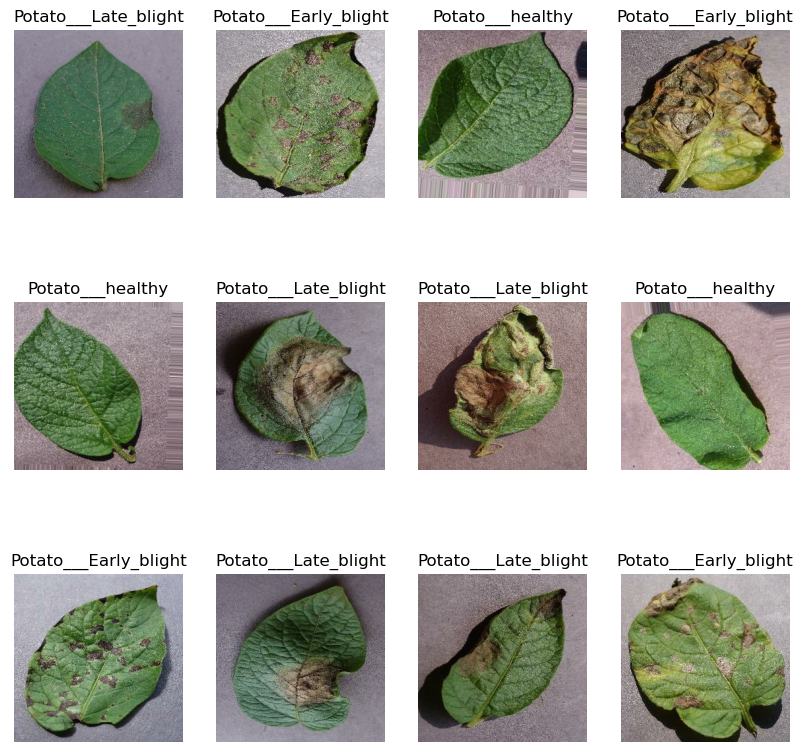

In [6]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [7]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size, seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [8]:
print(len(train_ds), len(val_ds), len(test_ds))

50 6 7


In [9]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [11]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (24, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (24, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (24, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (24, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (24, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (24, 62, 62, 64)         0         
 2D)                                                  

In [12]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/20
50/50 [==============================] - 48s 905ms/step - loss: 0.8877 - accuracy: 0.5354 - val_loss: 0.4252 - val_accuracy: 0.8542
Epoch 2/20
50/50 [==============================] - 48s 969ms/step - loss: 0.4433 - accuracy: 0.7997 - val_loss: 0.3124 - val_accuracy: 0.8681
Epoch 3/20
50/50 [==============================] - 47s 931ms/step - loss: 0.3845 - accuracy: 0.8409 - val_loss: 0.2764 - val_accuracy: 0.8542
Epoch 4/20
50/50 [==============================] - 47s 939ms/step - loss: 0.3288 - accuracy: 0.8746 - val_loss: 0.4801 - val_accuracy: 0.8194
Epoch 5/20
50/50 [==============================] - 47s 935ms/step - loss: 0.2888 - accuracy: 0.8914 - val_loss: 0.2368 - val_accuracy: 0.9028
Epoch 6/20
50/50 [==============================] - 47s 943ms/step - loss: 0.2430 - accuracy: 0.9091 - val_loss: 0.2116 - val_accuracy: 0.9167
Epoch 7/20
50/50 [==============================] - 48s 960ms/step - loss: 0.2303 - accuracy: 0.8990 - val_loss: 0.1684 - val_accuracy: 0.9514

In [13]:
scores=model.evaluate(test_ds)
scores

7/7 [==============================] - 2s 187ms/step - loss: 0.0965 - accuracy: 0.9702


[0.09648531675338745, 0.9702380895614624]

In [14]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [15]:
history.history['loss']

[0.8876579999923706,
 0.4433255195617676,
 0.38448473811149597,
 0.3287937343120575,
 0.2887550890445709,
 0.2430158108472824,
 0.23034457862377167,
 0.2436661571264267,
 0.23451648652553558,
 0.2121259719133377,
 0.1819782704114914,
 0.1822037547826767,
 0.1799907684326172,
 0.1673075407743454,
 0.20329441130161285,
 0.16203555464744568,
 0.10939739644527435,
 0.15650665760040283,
 0.1703987866640091,
 0.16047199070453644]

In [16]:
history.history['accuracy']

[0.5353535413742065,
 0.7996633052825928,
 0.8409090638160706,
 0.874579131603241,
 0.8914141654968262,
 0.9090909361839294,
 0.8989899158477783,
 0.9031986594200134,
 0.9158248901367188,
 0.9149831533432007,
 0.932659924030304,
 0.9276094436645508,
 0.9267676472663879,
 0.936026930809021,
 0.9175084233283997,
 0.932659924030304,
 0.9638047218322754,
 0.9427609443664551,
 0.93855220079422,
 0.9469696879386902]

In [17]:
history.history['val_loss']

[0.42521998286247253,
 0.3123987913131714,
 0.2763875722885132,
 0.4800528287887573,
 0.2367834448814392,
 0.21164298057556152,
 0.16835848987102509,
 0.2843482494354248,
 0.26104602217674255,
 0.2469656765460968,
 0.27539101243019104,
 0.19019949436187744,
 0.14470693469047546,
 0.1513228863477707,
 0.1777997612953186,
 0.29754531383514404,
 0.21097306907176971,
 0.22383086383342743,
 0.1851920485496521,
 0.1451456993818283]

In [18]:
history.history['val_accuracy']

[0.8541666865348816,
 0.8680555820465088,
 0.8541666865348816,
 0.8194444179534912,
 0.9027777910232544,
 0.9166666865348816,
 0.9513888955116272,
 0.875,
 0.8958333134651184,
 0.8819444179534912,
 0.8819444179534912,
 0.9236111044883728,
 0.9513888955116272,
 0.9236111044883728,
 0.9236111044883728,
 0.8819444179534912,
 0.9305555820465088,
 0.9027777910232544,
 0.9305555820465088,
 0.9305555820465088]

In [19]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

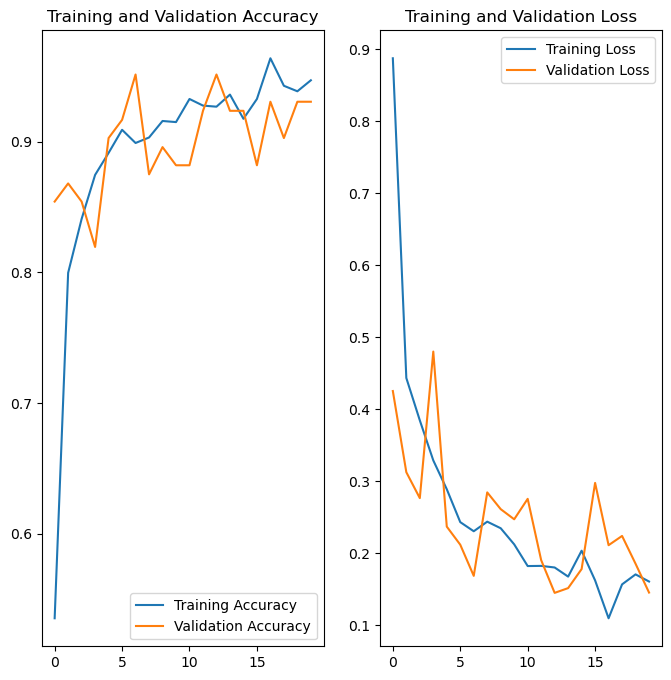

In [20]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [21]:
true_labels = []
pred_labels = []
for images_batch, labels_batch in test_ds.take(7):
    batch_prediction=model.predict(images_batch).argmax(axis=1)
    for i in labels_batch:
        true_labels.append(i)
    for i in batch_prediction:
        pred_labels.append(i)

1/1 [==============================] - 0s 258ms/step


In [22]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 47ms/step


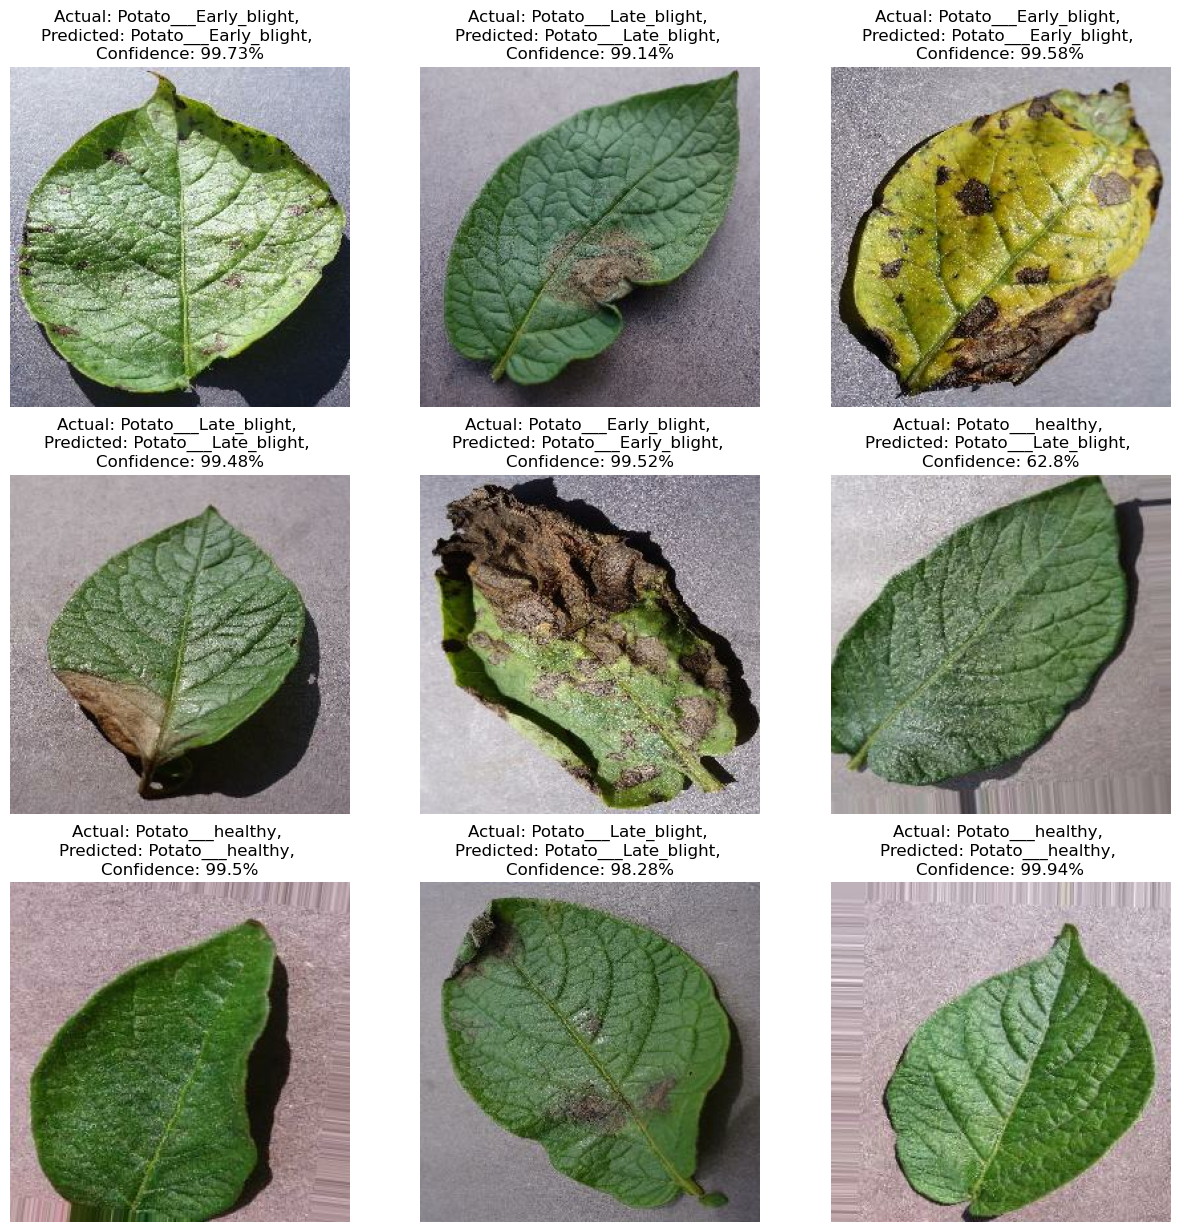

In [23]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \nPredicted: {predicted_class}, \nConfidence: {confidence}%")
        plt.axis("off")

In [24]:
print ("Classification Report: \n", classification_report(true_labels, pred_labels))

Classification Report: 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        55
           1       0.93      0.98      0.96        57
           2       1.00      0.93      0.96        56

    accuracy                           0.97       168
   macro avg       0.97      0.97      0.97       168
weighted avg       0.97      0.97      0.97       168



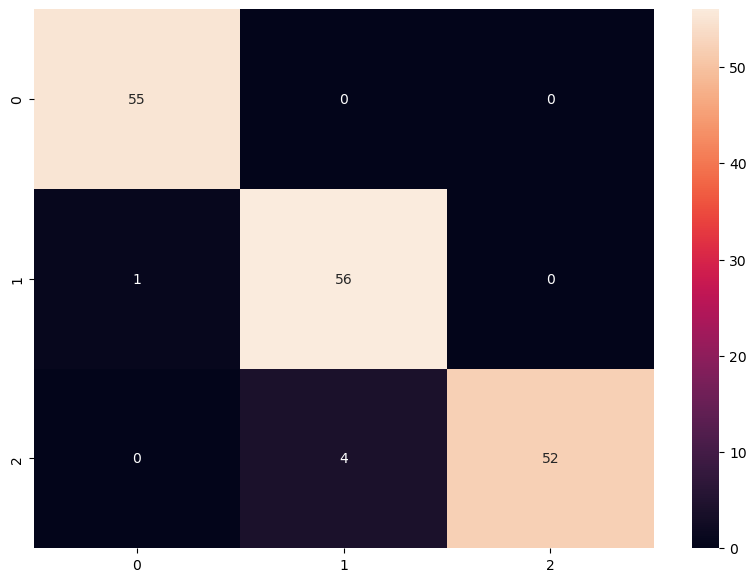

In [25]:
cm=tf.math.confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True,fmt='d')
plt.xlabel=('Predicted')
plt.ylabel=('Truth')

In [26]:
filename = "Model1-2-BatchSize24.joblib"
joblib.dump(model, filename)

['Model1-2-BatchSize24.joblib']